In [ ]:
import numpy as np
import pandas as pd
from io import StringIO
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!cp gdrive/My\ Drive/adult.csv ./

In [9]:
df = pd.read_csv('adult.csv')

In [10]:
df.drop_duplicates(keep='first', inplace = True)

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
df.shape

(48790, 15)

### تهیه گزارش کلی تحلیل ویژگی ها در قالب فایل مجزا

In [13]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile.to_file('PreProfiling.html')

##### above EDA file sent in courseware

##### fill missing values properties which contains missing records with the mod of that property

In [14]:
values, counts = np.unique(df['workclass'], return_counts = True)
most_freq_value = values[np.argmax(counts, axis = 0)]
df['workclass'][df['workclass'] == '?'] = most_freq_value
values, counts = np.unique(df['occupation'], return_counts = True)
most_freq_value = values[np.argmax(counts, axis = 0)]
df['occupation'][df['occupation'] == '?'] = most_freq_value
values, counts = np.unique(df['native-country'], return_counts = True)
most_freq_value = values[np.argmax(counts, axis = 0)]
df['native-country'][df['native-country'] == '?'] = most_freq_value

## visualization

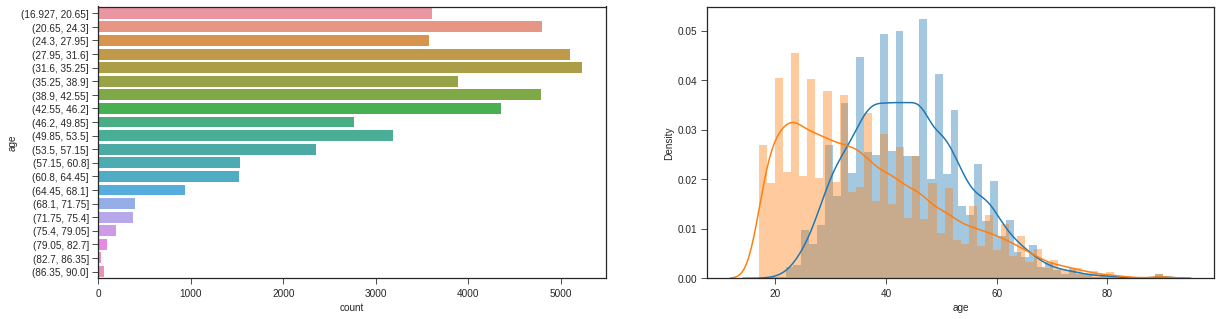

In [15]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y=pd.cut(df['age'], 20), data=df)
plt.subplot(1, 2, 2)
sns.distplot(df[df['income'] == '>50K']['age'], kde_kws={"label": ">$50K"})
sns.distplot(df[df['income'] == '<=50K']['age'], kde_kws={"label": "<=$50K"})

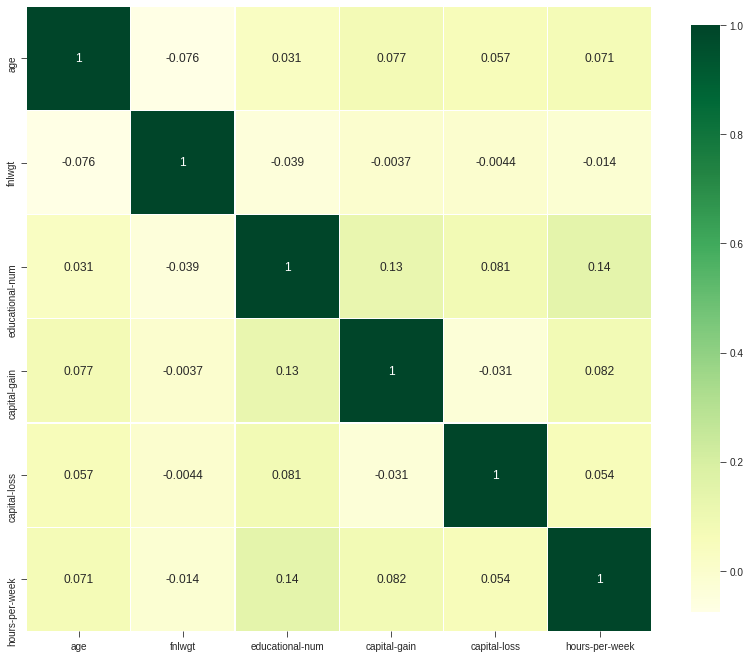

In [16]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = "YlGn",
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

correlation_heatmap(df)

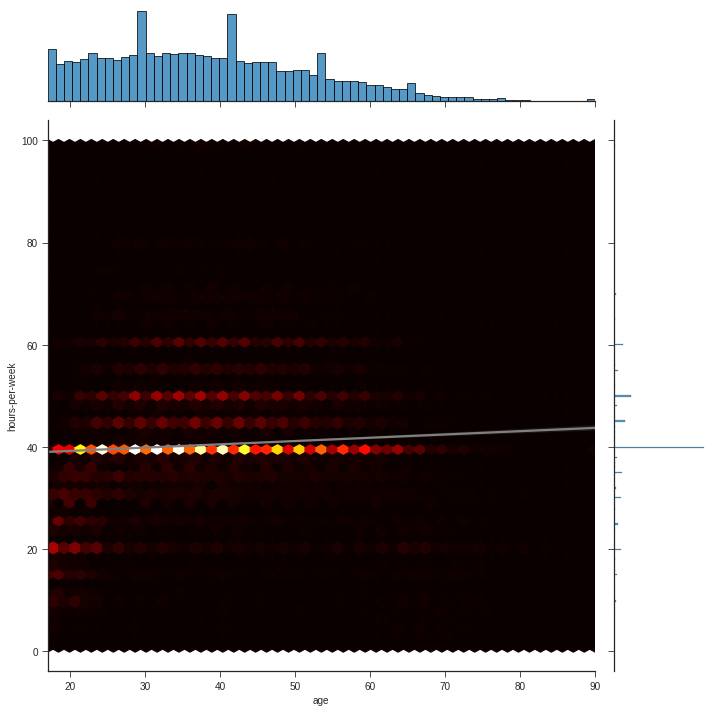

In [17]:
g = sns.jointplot(x = 'age', 
              y = 'hours-per-week',
              data = df, 
              kind = 'hex', 
              cmap= 'hot', 
              size=10)
sns.regplot(df.age, df['hours-per-week'], ax=g.ax_joint, scatter=False, color='grey')

##### convert target class to one hot values

In [18]:
df['income'][df['income'] == '<=50K'] = 0
df['income'][df['income'] == '>50K'] = 1

##### education has full corelation with education-num and education-num is ordinal property we can use

In [19]:
df.drop(columns=['education'], inplace=True)

In [20]:
df.head(10)

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,Private,103497,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,0
5,34,Private,198693,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
6,29,Private,227026,9,Never-married,Prof-specialty,Unmarried,Black,Male,0,0,40,United-States,0
7,63,Self-emp-not-inc,104626,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0


## encode categorical and numeric features and select best corelated features to target

In [21]:
categorical_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender']
df = pd.get_dummies(df, columns = categorical_cols, drop_first = True)

In [22]:
df

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male
0,25,226802,7,0,0,40,United-States,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,38,89814,9,0,0,50,United-States,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,28,336951,12,0,0,40,United-States,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
3,44,160323,10,7688,0,40,United-States,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,18,103497,10,0,0,30,United-States,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48785,27,257302,12,0,0,38,United-States,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
48786,40,154374,9,0,0,40,United-States,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
48787,58,151910,9,0,0,40,United-States,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
48788,22,201490,9,0,0,20,United-States,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1


In [23]:
df = df.apply(LabelEncoder().fit_transform)

#### according to perform below cell, binning is not useful in this dataset because pearson correlation decreases

In [24]:
# df['age_bucket'] = pd.cut(df['age'], 10)
# df['hour_bucket'] = pd.cut(df['hours-per-week'], 10)

In [25]:
selectedFeatures =abs(df.corr().income).nlargest(11)
print(selectedFeatures)
selectedFeatures =abs(df.corr().income).nlargest(11).keys()

income                               1.000000
marital-status_Married-civ-spouse    0.445663
capital-gain                         0.339172
educational-num                      0.332802
marital-status_Never-married         0.318512
age                                  0.230144
hours-per-week                       0.229000
relationship_Own-child               0.225688
gender_Male                          0.214639
occupation_Exec-managerial           0.210818
relationship_Not-in-family           0.190100
Name: income, dtype: float64


##### با دسته بندی و باکت کردن ساعت کاری و سن می بینیم که همبستگی کاهش می یابد. پس از مقدار نرمالایز شده این مقادیر استفاده می کنیم 

In [26]:
selectedFeatures

Index(['income', 'marital-status_Married-civ-spouse', 'capital-gain',
       'educational-num', 'marital-status_Never-married', 'age',
       'hours-per-week', 'relationship_Own-child', 'gender_Male',
       'occupation_Exec-managerial', 'relationship_Not-in-family'],
      dtype='object')

In [27]:
df = df[selectedFeatures]

In [28]:
from sklearn.model_selection import train_test_split
# split 25% for test
train,test = train_test_split(df)
xtrain = train.drop( labels=['income'] ,axis=1)
ytrain = train['income']
xtest = test.drop( labels=['income'] ,axis=1)
ytest = test['income']

### standardization

In [29]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

In [30]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
# only scale the test set with distibution of training set because we can't see all the model inputs
xtest = scaler.transform(xtest)

In [31]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [32]:
df

,income,marital-status_Married-civ-spouse,capital-gain,educational-num,marital-status_Never-married,age,hours-per-week,relationship_Own-child,gender_Male,occupation_Exec-managerial,relationship_Not-in-family
0,0,0,0,6,1,8,39,1,1,0,0
1,0,1,0,8,0,21,49,0,1,0,0
2,1,1,0,11,0,11,39,0,1,0,0
3,1,1,98,9,0,27,39,0,1,0,0
4,0,0,0,9,1,1,29,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
48785,0,1,0,11,0,10,37,0,0,0,0
48786,1,1,0,8,0,23,39,0,1,0,0
48787,0,0,0,8,0,41,39,0,0,0,0
48788,0,0,0,8,1,5,19,1,1,0,0


In [33]:
xtrain[0]

array([ 1.086656  , -0.27872611,  1.52497554, -0.70092714, -0.19732656,
       -0.02974044, -0.42901497,  0.70474572, -0.37768111, -0.58812234])

In [34]:
xtrain

array([[ 1.086656  , -0.27872611,  1.52497554, ...,  0.70474572,
        -0.37768111, -0.58812234],
       [-0.92025443, -0.27872611, -0.41701402, ...,  0.70474572,
        -0.37768111,  1.70032649],
       [-0.92025443, -0.27872611, -0.02861611, ...,  0.70474572,
        -0.37768111, -0.58812234],
       ...,
       [-0.92025443, -0.27872611, -0.41701402, ...,  0.70474572,
        -0.37768111,  1.70032649],
       [-0.92025443,  4.03144344,  1.13657763, ..., -1.4189515 ,
        -0.37768111,  1.70032649],
       [-0.92025443, -0.27872611, -0.41701402, ...,  0.70474572,
        -0.37768111, -0.58812234]])

### dimensionality reduction with PCA

### using grid search to find best SVM hyperparameters

### using cross validation to avoid specialization and overfitting

In [35]:
%%time
pca = PCA()
svm = SVC(gamma='auto')
pipe = Pipeline(steps=[('pca', pca), ('svm', svm)])

param_grid = {
    'pca__n_components': [1,2,3,4,5,6,7,8,9],
    'svm__kernel':['rbf', 'linear'],
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(xtrain, ytrain)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.849):
{'pca__n_components': 8, 'svm__kernel': 'rbf'}
CPU times: user 32.9 s, sys: 546 ms, total: 33.5 s
Wall time: 20min 55s


In [36]:
y_pred=search.predict(xtest)

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score,accuracy_score

In [43]:
accuracy_score(ytest, y_pred)

0.8488276766683063

## KNN

In [50]:
ytrain = ytrain.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

In [64]:
from math import sqrt

In [87]:
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

In [88]:
def getKNN(train, item, k):
    distances = list()
    for ind, row in enumerate(train):
        dist = euclidean_distance(item, row)
        distances.append((ind, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

In [89]:
def predict_KNN(xtrain, ytrain, test_row, k):
    neighbors = getKNN(xtrain, test_row, k)
    output_values = [ytrain[ind] for ind in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

In [90]:
def predict_dataset(xtrain, ytrain, k, xtest):
    y_pred = list()
    for i in xtest:
        y_pred.append(predict_KNN(xtrain, ytrain, i, k))
    return y_pred

In [91]:
%%time
y_pred = predict_dataset(xtrain, ytrain, 5, xtest)

CPU times: user 26.3 s, sys: 179 ms, total: 26.5 s
Wall time: 36min 41s


In [92]:
accuracy_score(ytest, y_pred)

0.8721856041974094
